# Metryki

In [4]:
#wczytanie modelu jako chmury punktow
import plyfile
import numpy as np
# data = plyfile.PlyData.read('./YCB_Video/YCB_Video_ext/models/035_power_dril/power_drill_points.ply')['vertex']
data = plyfile.PlyData.read('../lab6/power_drill_points.ply')['vertex']
model_ply = np.c_[data['x'], data['y'], data['z']]

In [7]:
camera_matrix = np.load("../lab6/camera_matrix.npy")

In [8]:
def hamilton_product(quat_1,quat_2):
    quat_out = np.zeros(4)
    quat_out[0] = quat_1[0]*quat_2[0] - quat_1[1]*quat_2[1]-quat_1[2]*quat_2[2]-quat_1[3]*quat_2[3]
    quat_out[1] = quat_1[0]*quat_2[1] + quat_1[1]*quat_2[0]+quat_1[2]*quat_2[3]-quat_1[3]*quat_2[2]
    quat_out[2] = quat_1[0]*quat_2[2] - quat_1[1]*quat_2[3]+quat_1[2]*quat_2[0]+quat_1[3]*quat_2[1]
    quat_out[3] = quat_1[0]*quat_2[3] + quat_1[1]*quat_2[2]-quat_1[2]*quat_2[1]+quat_1[3]*quat_2[0]
    return quat_out

def rotate_quat(points, quat): #rotacja punktów przy pomocy kwaternionu
    # xyzw -> wxyz
    quat_wxyz = quat.copy()
    quat_wxyz[0] = quat[3]
    quat_wxyz[1:] = quat[:3]

    points_vec = np.zeros((points.shape[0],4))
    points_vec[:,1:] =  points

    quat_tmp = quat_wxyz.copy()
    quat_tmp[1:] = -quat_tmp[1:]
    quat_1 = quat_tmp/np.sqrt(quat_tmp[0]**2+quat_tmp[1]**2+quat_tmp[2]**2+quat_tmp[3]**2)
    #hamilton produkt qpq^-1
    points_out = np.zeros(points.shape)
    for i in range(points.shape[0]):
        points_out[i] = hamilton_product(hamilton_product(quat_wxyz,points_vec[i]),quat_1)[1:]

    return points_out

#rzutowanie punktów na zdjęcie
def project(pose, points, camera_matrix): # pose[quat(x,y,z,w), translation(x,y,z)], punkty[x,y,z], macierz kamery
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate_quat(points, pose[:4]) #rotation
    points_proj += pose[4:] #translation

    for i in range(points_proj.shape[0]):
        pixel_point = camera_matrix @ points_proj[i]
        points_proj[i,:2] = pixel_point[:2]/pixel_point[2]
    points_proj = points_proj[:,:2]
    return points_proj

In [10]:
import cv2
trainImg = cv2.imread("../lab6//000001-color.png")
trainImg= cv2.cvtColor(trainImg, cv2.COLOR_BGR2RGB)

In [11]:
pose = np.array([0.30252337,  0.47923383,  0.65995039, -0.49323426, -0.11394919, 0.05734401,  0.96302502])

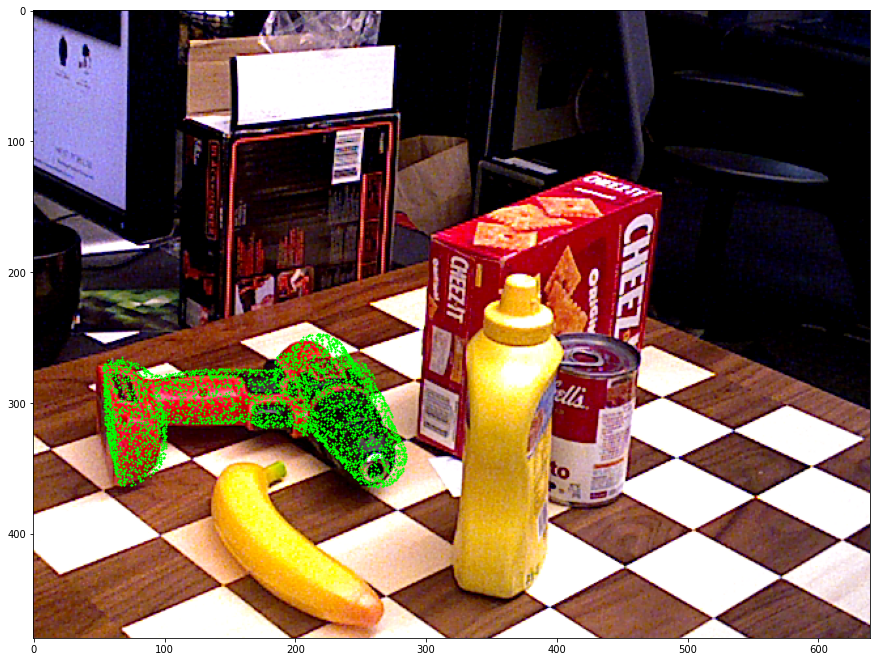

In [12]:
#TODO - rzutowanie chmury punktow
projection_points = project(pose, model_ply, camera_matrix)

plt.figure(figsize=(15, 13))
plt.imshow(trainImg)
plt.scatter(projection_points[:, 0], projection_points[:, 1], s=1, c='lime')

plt.show()

In [13]:
#TODO - rzutowanie prostopadloscianu
x_min, x_max = np.min(model_ply[:, 0]), np.max(model_ply[:, 0])
y_min, y_max = np.min(model_ply[:, 1]), np.max(model_ply[:, 1])
z_min, z_max = np.min(model_ply[:, 2]), np.max(model_ply[:, 2])

model_cuboid = np.array([
    [x_min, y_min, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_max, z_min],
    [x_min, y_min, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],
    [x_min, y_max, z_max],
])

model_cuboid_edges_points = np.array([
    [0, 1], [1, 2], [2, 3], [3, 0],
    [0, 4], [1, 5], [2, 6], [3, 7],
    [4, 5], [5, 6], [6, 7], [7, 4]
])

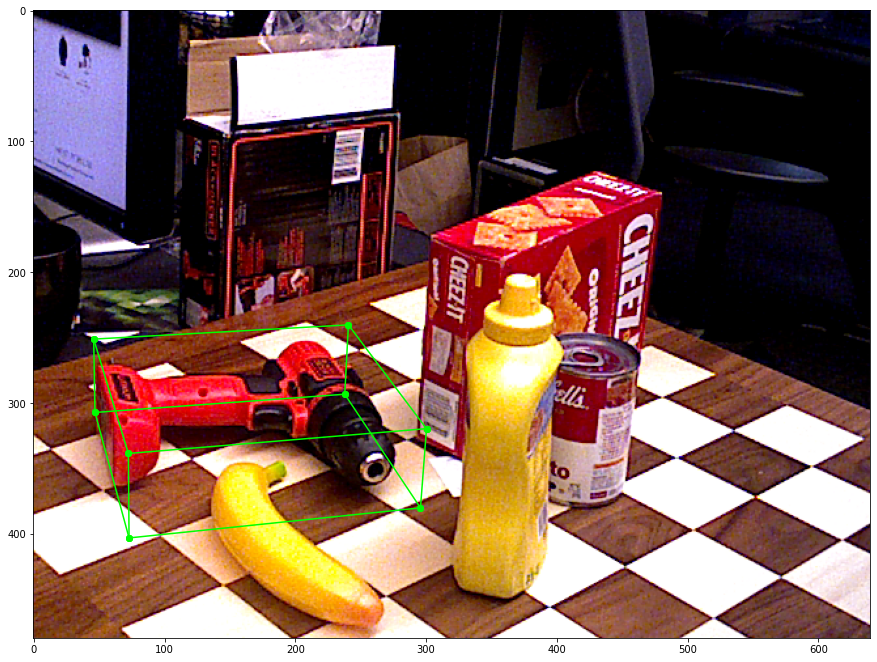

In [14]:
projection_cuboid = project(pose, model_cuboid, camera_matrix)

plt.figure(figsize=(15, 13))
plt.imshow(trainImg)
for a_idx, b_idx in model_cuboid_edges_points:
    a, b = projection_cuboid[a_idx], projection_cuboid[b_idx]
    plt.plot([a[0], b[0]], [a[1], b[1]], c='lime', marker='o')

In [15]:
from scipy.spatial.transform import Rotation as R

def add(rot, rot_gt, model): 
    pts_est = transform_points(model,rot)
    pts_gt = transform_points(model,rot_gt)
    diff = pts_est - pts_gt
    error = np.mean(np.sqrt(np.sum(diff**2, axis=1)))
    return error
    
def transform_points(model,rot):
    model_2 = np.ones((model.shape[0],4))
    model_2[:,:3] = model
    pts_new =  model_2.dot(rot.T)
    return pts_new

def count_add(GT, pose_estimation, model_ply):
 
    rot_gt = np.zeros((3,4))
    r = R.from_quat(GT[:4])
    rot_gt[:,:3] = r.as_matrix()
    rot_gt[:,3] = GT[4:] #translacja

    rot = np.zeros((3,4))
    r = R.from_quat(pose_estimation[:4])
    rot[:,:3] = r.as_matrix()
    rot[:,3] = pose_estimation[4:]

    return add(rot,rot_gt,model_ply)

def adds(rot, rot_gt, model):
    """
    Average Distance of Model Points for objects with indistinguishable views
    - by Hinterstoisser et al. (ACCV 2012).
    :param R_est, t_est: Estimated pose (3x3 rot. matrix and 3x1 trans. vector).
    :param R_gt, t_gt: GT pose (3x3 rot. matrix and 3x1 trans. vector).
    :param model: Object model given by a dictionary where item 'pts'
    is nx3 ndarray with 3D model points.
    :return: Error of pose_est w.r.t. pose_gt.
    """
    pts_est = transform_points(model, rot)
    pts_gt = transform_points(model, rot_gt)

    # Calculate distances to the nearest neighbors from pts_gt to pts_est
    nn_index = spatial.cKDTree(pts_est)
    nn_dists, _ = nn_index.query(pts_gt, k=1)

    e = nn_dists.mean()
    return e

from scipy.spatial.transform import Rotation as R

def rep_err(rot, rot_gt, model): 
    pts_est = transform_points_rep(model,rot)
    pts_gt = transform_points_rep(model,rot_gt)
    diff = pts_est - pts_gt
    error = np.mean(np.sqrt(np.sum(diff**2, axis=0)))
    return error
    
def transform_points_rep(model,rot):
    model_2 = np.ones((model.shape[0],4))
    model_2[:,:3] = model
    pts_new = camera_matrix @ rot @ model_2.T
    pts_new[:2] = pts_new[:2] / pts_new[2]
    return pts_new[:2]

def count_rep_err(GT, pose_estimation, model_ply):
 
    rot_gt = np.zeros((3,4))
    r = R.from_quat(GT[:4])
    rot_gt[:,:3] = r.as_matrix()
    rot_gt[:,3] = GT[4:] #translacja

    rot = np.zeros((3,4))
    r = R.from_quat(pose_estimation[:4])
    rot[:,:3] = r.as_matrix()
    rot[:,3] = pose_estimation[4:]

    return rep_err(rot,rot_gt,model_ply)

---

In [16]:
import pandas as pd
import numpy as np
import cv2

from matplotlib import pyplot as plt

from scipy.spatial.transform import Rotation

import os

# Load data

## Drill 3D

In [17]:
drill_3d_points = np.load('data/drill_3d_points/power_drill_punkty_3d.npy')
drill_3d_points.shape

(9, 3)

## Camera position

In [18]:
camera_matrix = np.load('data/camera_coords/camera_matrix.npy')
camera_matrix

array([[1.066778e+03, 0.000000e+00, 3.129869e+02],
       [0.000000e+00, 1.067487e+03, 2.413109e+02],
       [0.000000e+00, 0.000000e+00, 1.000000e+00]])

## Keypoints

In [19]:
dataset_numbers = ['10', '11', '18', '24', '30', '37', '50']

keypoints = np.vstack([np.load(f'data/keypoints/00{no}_gt_keypoints2d.npy') for no in dataset_numbers])
keypoints = keypoints.reshape((-1, 9, 2))
keypoints = keypoints.astype('double')
keypoints.shape

(1842, 9, 2)

## Poses

In [20]:
poses = [np.load(f'data/poses/00{no}_gt.npy')[::6] for no in dataset_numbers]
poses = np.vstack(poses)
poses.shape

(1842, 7)

In [21]:
pose_translations = poses[:, 4:]
pose_translations.shape

(1842, 3)

In [22]:
pose_rotations = Rotation.from_quat(poses[:, :4]).as_rotvec()
pose_rotations.shape

(1842, 3)

# Pose estimation

In [23]:
dist_coeffs = np.zeros((4, 1))

pred_rotations = []
pred_translations = []
for i in range(poses.shape[0]):
    success, rvec, tvec = cv2.solvePnP(drill_3d_points, keypoints[i], camera_matrix, dist_coeffs)
    
    pred_rotations.append(rvec.reshape((1, -1)))
    pred_translations.append(tvec.reshape((1, -1)))
    
pred_rotations = np.vstack(pred_rotations)
pred_translations = np.vstack(pred_translations)

pred_rotations.shape, pred_translations.shape

((1842, 3), (1842, 3))

In [24]:
pred_poses = np.hstack([pred_rotations, pred_translations])
pred_poses.shape

(1842, 6)

# Evaluation - mse

In [25]:
pred_rotations[:5].T, pose_rotations[:5].T

(array([[-1.81214115, -1.81001715, -1.81142983, -1.81224527, -1.81139478],
        [ 0.51238267,  0.51645337,  0.51221198,  0.51237927,  0.52594926],
        [-1.61848064, -1.62624475, -1.65227964, -1.65471971, -1.65691316]]),
 array([[-1.81269148, -1.8113978 , -1.81125669, -1.81313823, -1.81170269],
        [ 0.51502142,  0.51449783,  0.50913042,  0.51261426,  0.52680785],
        [-1.61586563, -1.62717492, -1.65320064, -1.65517276, -1.65799588]]))

In [26]:
pred_translations[:5].T, pose_translations[:5].T

(array([[ 0.04834727,  0.04173118,  0.03512788,  0.03461976,  0.03216235],
        [-0.01579899, -0.00914486, -0.00375752, -0.00570792, -0.0094738 ],
        [ 0.70843554,  0.71201948,  0.71335241,  0.71752598,  0.71603525]]),
 array([[ 0.04861259,  0.04207013,  0.03560334,  0.03494189,  0.03254118],
        [-0.01542717, -0.00866813, -0.00327022, -0.00539577, -0.00912025],
        [ 0.70811999,  0.71079381,  0.71466958,  0.71640753,  0.71576861]]))

In [27]:
from sklearn.metrics import mean_squared_error

rotation_error = mean_squared_error(pose_rotations, pred_rotations)
translations_error = mean_squared_error(pose_translations, pred_translations)
print(f'Rotations error: {rotation_error}, Translations error: {translations_error}')

Rotations error: 6.970456594374539e-06, Translations error: 6.979103980339737e-07


# Examples (do not work)

In [13]:
new_pred_rotations = np.copy(pred_rotations)

new_pred_rotations = Rotation.from_rotvec(new_pred_rotations).as_euler('xyz')

new_pred_rotations[:, 0] = 0.5 * np.pi
new_pred_rotations[:, 1] -= 0.5 * np.pi
new_pred_rotations[:, 2] -= 0.5 * np.pi

new_pred_rotations = Rotation.from_euler('xyz', new_pred_rotations).as_rotvec()

In [14]:
def plot_img(idx):    
    file_names = os.listdir('./data/images/0010')
    file_name = file_names[idx]
    print(file_name)

    img = cv2.imread(f'data/images/0010/{file_name}')

    nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), new_pred_rotations[idx], pred_translations[idx], camera_matrix, dist_coeffs)

    for p in keypoints[idx]:
      cv2.circle(img, (int(p[0]), int(p[1])), 3, (0,255,255), -1)

    point1 = (int(keypoints[idx][0][0]), int(keypoints[idx][0][1]))

    point2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

    cv2.line(img, point1, point2, (255, 0, 0), 2)

    #Show the image with matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.show()

000001-color.png


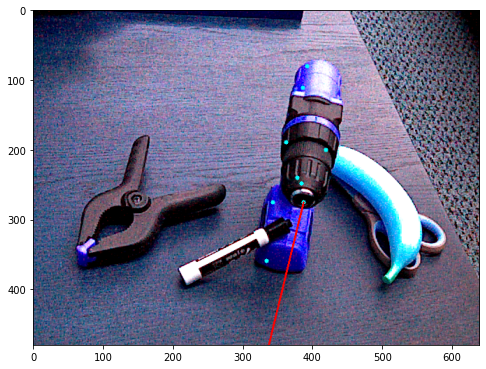

000181-color.png


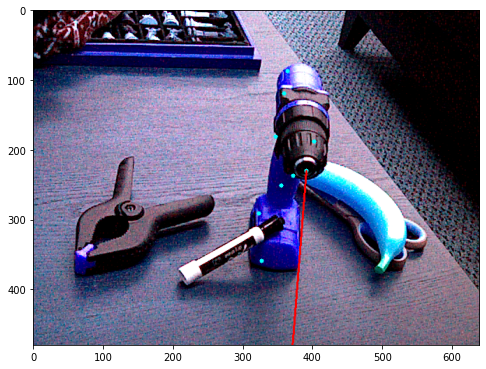

000361-color.png


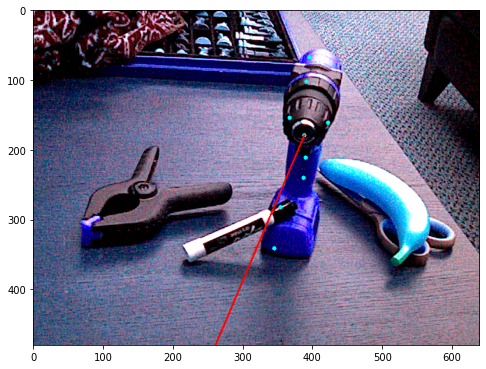

000541-color.png


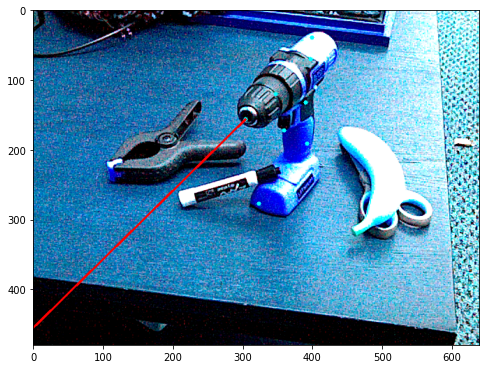

000721-color.png


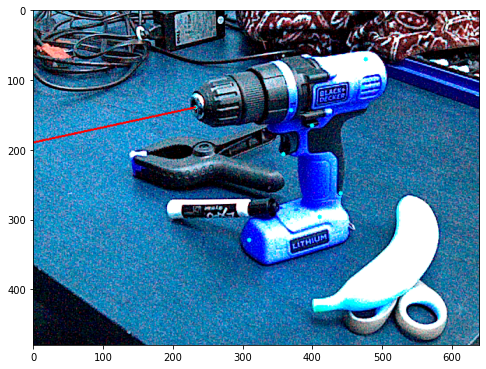

000901-color.png


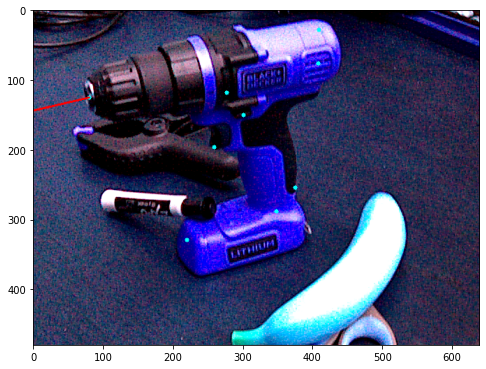

001081-color.png


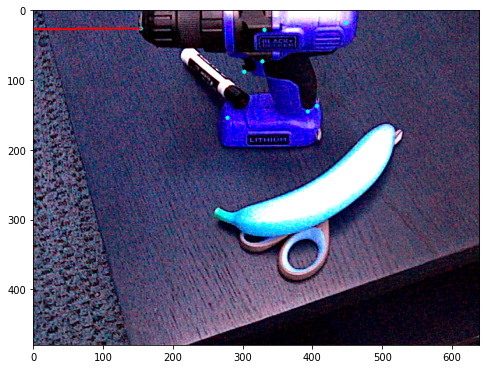

001261-color.png


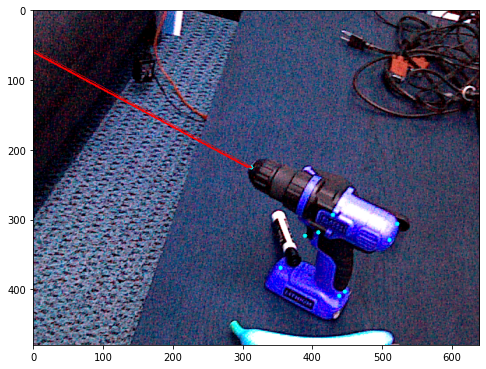

001441-color.png


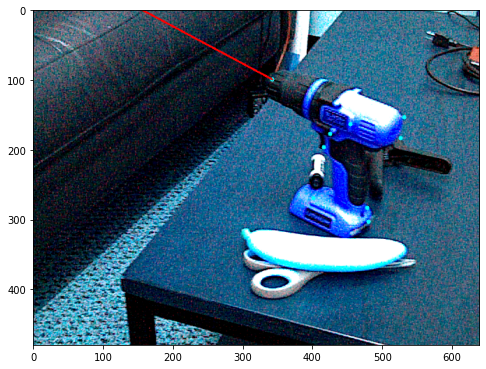

001621-color.png


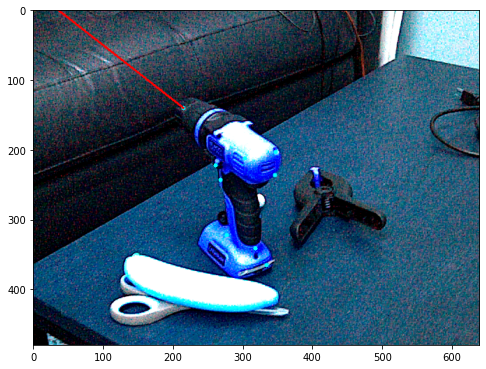

001801-color.png


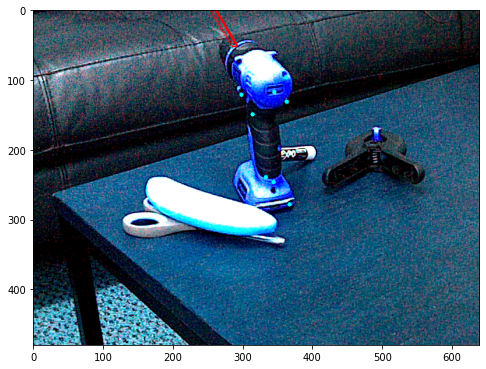

In [15]:
for idx in range(0, 320, 30):
    plot_img(idx)